In [1]:
# Configure JAX
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Defining some useful functions

In [3]:
import numpy as np
from qiskit import pulse

from twoqutritpulsesimulator import TwoQutritPulseSimulator
from statetomography import TwoQutritStateTomography

In [4]:
sim = TwoQutritPulseSimulator()
backend = sim.get_backend()

In [5]:
dchan0 = pulse.DriveChannel(0)
dchan1 = pulse.DriveChannel(1)

uchan0 = pulse.ControlChannel(0)
uchan1 = pulse.ControlChannel(1)

achan0 = pulse.AcquireChannel(0)
achan1 = pulse.AcquireChannel(1)

memslot0 = pulse.MemorySlot(0)
memslot1 = pulse.MemorySlot(1)

In [6]:
def get_cr01_pulse(amp):
    dur = Parameter('duration')
    with pulse.build(name="cr_01") as cr01_pulse:        
        pulse.set_frequency(freq_1, uchan0)
        pulse.play(pulse.GaussianSquare(dur, amp, 76, 0.9*dur, limit_amplitude=False), uchan0)
    return cr01_pulse

def get_cr12_pulse(amp):
    dur = Parameter('duration')
    with pulse.build(name="cr_12") as cr12_pulse:        
        pulse.set_frequency(ef_freq_1, uchan0)
        pulse.play(pulse.GaussianSquare(dur, amp, 76, 0.9*dur, limit_amplitude=False), uchan0)
    return cr12_pulse

In [7]:
from qiskit import pulse
from simulator_parameters_2q import get_parameter
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector

freq_0 = get_parameter('freq', 0)
freq_1 = get_parameter('freq', 1)

ef_freq_0 = get_parameter('ef_freq', 0)
ef_freq_1 = get_parameter('ef_freq', 1)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

def plot_dm(data1, data2):
    fig = plt.figure(figsize=(10, 5))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    def plot_single_dm(ax, data):
        dims = len(data[0])
        spacing = 1.5
        x_idx = np.arange(dims) * spacing
        y_idx = np.arange(dims) * spacing
        x, y = np.meshgrid(x_idx, y_idx)

        z = np.zeros(dims**2)
        dz = data.ravel()

        norm = Normalize(vmin=np.min(dz), vmax=np.max(dz))

        # Define colormaps
        pos_cmap = LinearSegmentedColormap.from_list("pos", ['#FFFFFF', '#ADD8E6'])
        neg_cmap = LinearSegmentedColormap.from_list("neg", ['#808080', '#FFFFFF'])

        def get_color(val):
            return pos_cmap(norm(val)) if val >= 0 else neg_cmap(norm(val))

        colors = [get_color(val) for val in dz]

        ax.bar3d(
            x.ravel(), y.ravel(), z, 1, 1, dz,
            shade=False, alpha=0.8, edgecolor='black', linewidth=0.5,
            color=colors
        )

        if dims == 3:
            labels = [f"|{i}⟩" for i in range(3)]
        elif dims == 9:
            labels = [f"|{i}{j}⟩" for i in range(3) for j in range(3)]
        elif dims == 81:
            labels = [f"l{i}l{j}" for i in range(9) for j in range(9)]
        else:
            raise Exception(f"Unsupported data dimension: {dims}")

        ax.set_xticks(x_idx + 0.5)
        ax.set_yticks(y_idx + 0.5)
        ax.set_xticklabels(labels, rotation=90, fontsize=6)
        ax.set_yticklabels(labels, fontsize=6)
        ax.tick_params(axis='z', labelsize=6)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('')

        return np.min(dz), np.max(dz)

    # Plot both axes
    min1, max1 = plot_single_dm(ax1, data1)
    min2, max2 = plot_single_dm(ax2, data2)

    # Combine color scales
    global_min = min(min1, min2)
    global_max = max(max1, max2)
    norm = Normalize(vmin=global_min, vmax=global_max)

    full_cmap = LinearSegmentedColormap.from_list(
        'combined',
        np.vstack((
            LinearSegmentedColormap.from_list("neg", ['#808080', '#FFFFFF'])(np.linspace(0, 1, 128)),
            LinearSegmentedColormap.from_list("pos", ['#FFFFFF', '#ADD8E6'])(np.linspace(0, 1, 128))
        ))
    )

    sm = ScalarMappable(norm=norm, cmap=full_cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, pad=0.1, location='right')
    cbar.set_label('Value')

    plt.tight_layout()
    plt.show()


# Constructing the two-qutrit Bell State

In this notebook, we construct the two-qutrit Bell state using the UCX01 and the UCH12 gates. To make the simulation simpler, we first simulate and obtain the matrices corersponding to the two gates and use that to obtain the Bell circuit using regular matrix multiplication.

*Note*: The simulation performed under the assumption that the SPAM error is zero.

## Obtaining the matrix corresponding to the simulated UCX01

In [9]:
dt = 1/4.5e9

amplitude = 1.1
duration = 900

cr_pulse = get_cr01_pulse(amplitude)
cr_pulse.assign_parameters({'duration': int(duration)})
t_span = [0., cr_pulse.duration*dt]

state_array = []
for i in range(9):
    y0 = np.array([0,0,0,0,0,0,0,0,0])
    y0[i] = 1
    y0 = Statevector(y0)
    cr_job = backend.solve(cr_pulse, t_span=t_span, y0=y0)
    state_array.append(cr_job[0].y[-1].data)
state_array = np.array(state_array)
candidate_gate_ucx01 = state_array.transpose()

In [10]:
global_phase_ucx01 = 1/(candidate_gate_ucx01[0][3]/np.abs(candidate_gate_ucx01[0][3]))

In [11]:
theta = -np.pi/14
phase_gate_0 = np.array([[1, 0, 0],[0, np.cos(theta)+(1j*np.sin(theta)), 0],[0, 0, (1/np.sqrt(2))-(1j/np.sqrt(2))]])

In [12]:
phase_gate_1 = global_phase_ucx01*np.kron(np.eye(3), phase_gate_0)

In [13]:
sim_ucx01 = np.matmul(phase_gate_1, candidate_gate_ucx01)

## Obtaining the matrix corresponding to the simulated UCH12

In [14]:
dt = 1/4.5e9

amplitude = 0.4
duration = 450

phase1 = 1.3615109172373014

cr_pulse = get_cr12_pulse(amplitude)
cr_pulse.assign_parameters({'duration': int(duration)})
t_span = [0., cr_pulse.duration*dt]

with pulse.build() as phase_pulse:
    pulse.shift_phase(phase1, uchan0)

state_array = []
for i in range(9):
    y0 = np.array([0,0,0,0,0,0,0,0,0])
    y0[i] = 1
    y0 = Statevector(y0)
    cr_job = backend.solve(phase_pulse.append(cr_pulse), t_span=t_span, y0=y0)
    state_array.append(cr_job[0].y[-1].data)
state_array = np.array(state_array)
candidate_gate_uch12 = state_array.transpose()

In [15]:
global_phase_uch12 = 1/(candidate_gate_uch12[1][1]/np.abs(candidate_gate_uch12[1][1]))
inter_gate_uch12 = global_phase_uch12*candidate_gate_uch12

In [16]:
phase_0 = 1/(inter_gate_uch12[0][0]/np.abs(inter_gate_uch12[0][0]))
phase_1 = 1
phase_2 = 1

phase_gate_0 = np.kron(np.eye(3), np.diag([phase_0, phase_1, phase_2]))

In [17]:
sim_uch12 = np.matmul(phase_gate_0, inter_gate_uch12)

### Constructing Bell Circuit and Applying it on the $\lvert 00\rangle$ state

In [18]:
initial_state = np.array([1,0,0,0,0,0,0,0,0])

In [19]:
H = (1/np.sqrt(3))*np.array([[1,1,1],[1,np.exp(2*np.pi*1j/3), np.exp(4*np.pi*1j/3)],[1, np.exp(4*np.pi*1j/3), np.exp(2*np.pi*1j/3)]])

In [20]:
V = np.array([[1,0,0],[0,1/np.sqrt(2), 1/np.sqrt(2)],[0,1/np.sqrt(2), -1/np.sqrt(2)]])

In [21]:
X01 = np.array([[0,1,0],[1,0,0],[0,0,1]])

In [22]:
H_tot = np.kron(np.eye(3), H)
V_tot = np.kron(V, np.eye(3))
X_tot = np.kron(X01, np.eye(3))

In [23]:
bell_circuit = np.matmul(np.matmul(X_tot, np.matmul(sim_uch12, V_tot)), np.matmul(sim_ucx01, H_tot))

In [24]:
sim_bell = np.matmul(bell_circuit, initial_state)

## Defining the ideal Bell state and computing the fidelity of the obtained state.

In [25]:
ideal_bell = (1/np.sqrt(3))*np.array([1,0,0,0,1,0,0,0,1])

In [26]:
bell_fid = np.abs(ideal_bell.dot(sim_bell))
print(bell_fid)

0.9905928142918754


## Performing QST of both the ideal and simulated state and comparing their density matrices

In [27]:
qst_ideal = TwoQutritStateTomography(state=ideal_bell)

In [28]:
qst_matrix_ideal = qst_ideal.run()
ideal_density_matrix = qst_ideal.qst_matrix_to_density_matrix()

In [29]:
qst_sim = TwoQutritStateTomography(state=sim_bell)

In [30]:
qst_matrix_sim = qst_sim.run()
sim_density_matrix = qst_sim.qst_matrix_to_density_matrix()

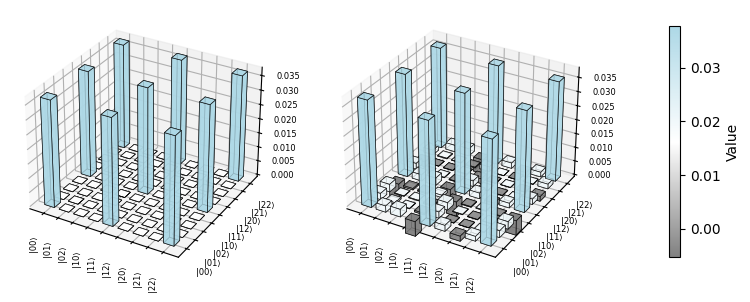

In [31]:
plot_dm(np.real(ideal_density_matrix), np.real(sim_density_matrix))

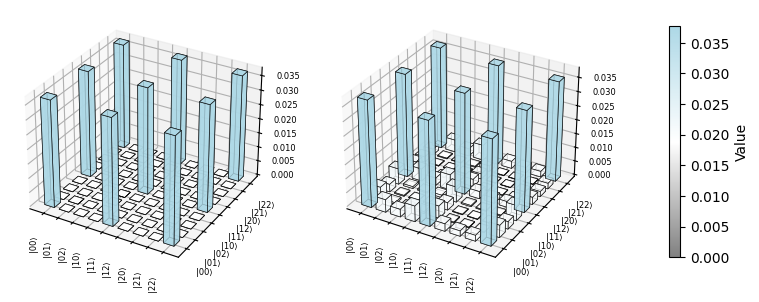

In [32]:
plot_dm(np.abs(ideal_density_matrix), np.abs(sim_density_matrix))